# Градиентный спуск
## Задача поиска оптимальных коэффициентов полиномиальной модели

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from livelossplot import PlotLosses
import time

Формируем синтетический датасет на основе полиномиальной функции с добавлением случайного шума:

${f(x) = \sum_{k=0}^{K-1}{w_k \cdot x^k} + \epsilon}$,

где ${w}$ - массив весов размера ${K}$

Определим полиномиальную функцию, в частном и в общем виде:

In [8]:
def f_trend(x):
    return x**3 - 3*x**2 + 2*x - 5

def f_poly(X, w_coeff):
    Y = np.zeros_like(X)
    for n, x in enumerate(X):
        for idx, w in enumerate(w_coeff.tolist()[0]):
            Y[n] = Y[n] + w * x**idx
    return Y

Сгенерируем синтетический датасет и построим графики.

<function matplotlib.pyplot.show(close=None, block=None)>

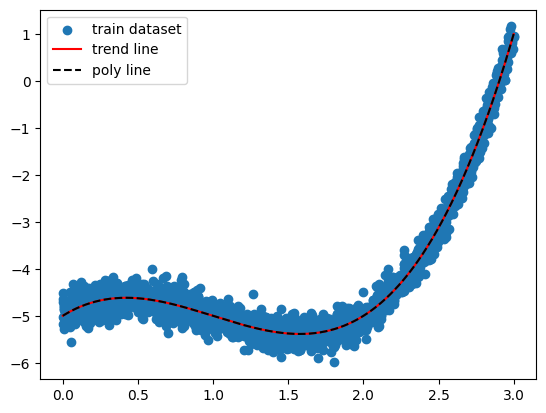

In [9]:
x_min = 0
x_max = 3
N_points = 2000
# Случайный набор x-ов.
X_train = np.random.uniform(low=x_min, high=x_max, size=(N_points,))
# Отклики с добавлением шума.
y_train = f_trend(X_train) + np.random.normal(0,0.2,N_points)

plt.scatter(X_train, y_train)
plt.plot(np.sort(X_train), f_trend(np.sort(X_train)), color='red')
plt.plot(np.sort(X_train), f_poly(np.sort(X_train), np.array([[-5, 2, -3, 1]])), '--', color='black')
plt.legend(['train dataset', 'trend line', 'poly line'])
plt.show

Функция ошибки:

In [10]:
def loss_func(X, y, w_coeff):
    return np.sum((y - f_poly(X, w_coeff))**2)

Функция поиска параметров методом градиентного спуска.

In [11]:
def model_fit(X_train, y_train, learning_rate, tolerance, beta, batch_ratio, lr_scaling, liveplot):
    t_init = time.time()
    if liveplot:
        liveloss = PlotLosses()
    batch_size = int(batch_ratio * len(X_train))
    
    iteration_max = 100000
    # Коэффициенты (веса) инициилизируются нулями.
    w_coeff = np.zeros((1,len(learning_rate)))
    # Буфер коэффициентов.
    w_coeff_buff = w_coeff.copy()
    
    # Градиенты инициализируются ненулевыми значениями.
    grad = np.ones_like(w_coeff)
    
    # Аккумулятор для фильтра градиента.
    grad_filter = np.zeros_like(grad)
    
    losses = []
    
    loss_filter = tolerance
    # Масштабирующий коэффициент, обратно пропорциональный значению ошибки.
    lr_scale = 1 / np.sqrt(1 + loss_filter)
    
    for i in range(iteration_max):
        for k, w in enumerate(w_coeff.tolist()[0]):
            # Накопление "момента".
            grad_filter[0,k] = beta * grad_filter[0,k] + (1 - beta) * grad[0,k]
            # Шаг градиентного спуска.
            if lr_scaling:
                w_step = - learning_rate[k] * lr_scale * grad_filter[0,k]
            else:
                w_step = - learning_rate[k] * grad_filter[0,k]
            # Сбрасываем коэффициенты до необновленных значений.
            w_coeff_1 = w_coeff.copy()
            w_coeff_2 = w_coeff.copy()
            # Модификация только k-го коэффициента:
            w_coeff_1[0,k] = w + w_step
            w_coeff_2[0,k] = w + 2*w_step

            # Выборка случайных элементов (по индексам).
            batch_indices = np.random.choice(len(X_train), size=batch_size, replace=True)
            X_train_batch = [X_train[idx] for idx in batch_indices]
            y_train_batch = [y_train[idx] for idx in batch_indices]
            
            # Формируем массив значений функции потерь, для вычисления градиента. Массив состоит из 3х элементов.
            loss_func_grad = [loss_func(X_train_batch, y_train_batch, w_coeff  ),
                              loss_func(X_train_batch, y_train_batch, w_coeff_1),
                              loss_func(X_train_batch, y_train_batch, w_coeff_2)]
            # Массив градиента состоит из 3х точек с индексами [0, 1, 2]. Берем предпоследнюю.
            grad[0,k] = np.gradient(loss_func_grad, w_step)[1]
            
            # Обновление оного коэффициента в итоговом массиве.
            w_coeff_buff[0,k] = w_coeff_1[0,k]
        # Обновление всех коэффициентов.
        w_coeff = w_coeff_buff.copy()
        # Вычисление ошибки на полном датасете, при обновленных коэффициентах.
        loss = loss_func(X_train, y_train, w_coeff)
        if lr_scaling:
            # Фильтр ошибки.
            loss_filter = 0.6 * loss_filter + (1 - 0.6) * loss
            lr_scale = 1 / np.sqrt(1 + loss_filter)
        # Накопление ошибки в отдельный массив для дальнейшей визуализации.
        losses.append(loss)
        
        if i % 100 == 0:
            print('Iteration:', i)
            print('Gradient:', np.round(grad[0],4))
            print('Weights:', np.round(w_coeff[0],4))
            print('MSE loss:', np.round(loss,4))
            if liveplot:
                if loss < 1000:
                    liveloss.update({'MSE loss': loss})
                    liveloss.draw()
        if (loss < tolerance):
            print('Tolerance reached')
            break
    iter_final = i
    fit_time = time.time() - t_init
    return w_coeff, losses, iter_final, fit_time

In [12]:
# Отключен Momentum.
# Обучение на полном датасете.
'''
weights_1, losses_1, iter_final_1, fit_time_1 = model_fit(X_train, y_train,
                                                          learning_rate=5*[1e-7],
                                                          tolerance=(0.1**2 * N_points),
                                                          beta=0,
                                                          batch_ratio=1.0,
                                                          lr_scaling=False,
                                                          liveplot=False)
'''
weights_1, losses_1, iter_final_1, fit_time_1 = model_fit(X_train, y_train,
                                                          learning_rate=[1e-3, 1e-4, 1e-5, 1e-6, 1e-7],
                                                          tolerance=(0.1**2 * N_points),
                                                          beta=0.8,
                                                          batch_ratio=0.1,
                                                          lr_scaling=True,
                                                          liveplot=False)

Iteration: 0
Gradient: [ 1672.2531  2246.4173  3958.2487  7058.4725 15402.4836]
Weights: [-0. -0. -0. -0. -0.]
MSE loss: 40788.3676
Iteration: 100
Gradient: [1355.3437 1455.1483 2630.8387 4866.6976 8043.6375]
Weights: [-8.061e-01 -1.020e-01 -1.700e-02 -3.300e-03 -7.000e-04]
MSE loss: 25923.8596
Iteration: 200
Gradient: [ 915.5299  861.3624 1228.5616 1763.9763 2245.3854]
Weights: [-1.5845e+00 -1.8970e-01 -3.0100e-02 -5.4000e-03 -1.0000e-03]
MSE loss: 15941.6381
Iteration: 300
Gradient: [  545.0633   430.1931   554.0144 -1237.7973 -2077.1514]
Weights: [-2.2479e+00 -2.5140e-01 -3.6100e-02 -5.6000e-03 -8.0000e-04]
MSE loss: 10468.3157
Iteration: 400
Gradient: [   346.1719    294.9181   -634.9538  -2527.0544 -11063.5848]
Weights: [-2.7647e+00 -2.8410e-01 -3.4500e-02 -3.9000e-03 -1.0000e-04]
MSE loss: 7760.0785
Iteration: 500
Gradient: [  237.7716  -130.1463  -964.0348 -3455.1009 -9194.9528]
Weights: [-3.1455e+00 -2.8810e-01 -2.8000e-02 -9.0000e-04  9.0000e-04]
MSE loss: 6339.264
Iteration: 

In [13]:
# Отключен Momentum.
# Обучение на полном датасете.
'''
weights_2, losses_2, iter_final_2, fit_time_2 = model_fit(X_train, y_train,
                                                          learning_rate=[1e-5, 1e-6, 1e-7, 1e-8, 1e-9],
                                                          tolerance=(0.1**2 * N_points),
                                                          beta=0,
                                                          batch_ratio=1.0,
                                                          lr_scaling=False,
                                                          liveplot=False)
'''
weights_2, losses_2, iter_final_2, fit_time_2 = model_fit(X_train, y_train,
                                                          learning_rate=[1e-3, 1e-4, 1e-5, 1e-6, 1e-7],
                                                          tolerance=(0.1**2 * N_points),
                                                          beta=0.8,
                                                          batch_ratio=0.2,
                                                          lr_scaling=False,
                                                          liveplot=False)

Iteration: 0
Gradient: [ 3400.8052  4570.6796  7765.9205 15435.8184 30668.746 ]
Weights: [-0.0002 -0.     -0.     -0.     -0.    ]
MSE loss: 40785.2674
Iteration: 100
Gradient: [   -8.7985    59.1038    36.3973  -304.8356 -2858.9992]
Weights: [-4.7679 -0.7461  0.1252  0.0871  0.04  ]
MSE loss: 435.23
Iteration: 200
Gradient: [ 18.6524  69.7329 157.7635 312.1449 217.6594]
Weights: [-4.4697 -1.0794  0.0994  0.1066  0.0506]
MSE loss: 280.3761
Iteration: 300
Gradient: [-19.0364 -28.8112 -40.9804  -7.6327  46.2884]
Weights: [-4.3384 -1.2305  0.0681  0.1142  0.0568]
MSE loss: 235.0955
Iteration: 400
Gradient: [  -5.2188   14.2047   57.7758  -29.6317 -316.2252]
Weights: [-4.2446 -1.2839  0.0423  0.1179  0.0612]
MSE loss: 218.2936
Iteration: 500
Gradient: [   2.3743    2.8088  -57.5475 -143.5241  -72.5136]
Weights: [-4.2114 -1.3099  0.0223  0.1191  0.0643]
MSE loss: 210.8083
Iteration: 600
Gradient: [   7.2547    3.933   -13.1975   82.296  -772.141 ]
Weights: [-4.2078 -1.3107  0.0074  0.1187  

In [14]:
'''
weights_3, losses_3, iter_final_3, fit_time_3 = model_fit(X_train, y_train,
                                                          learning_rate=[1e-3, 1e-4, 1e-5, 1e-6, 1e-7],
                                                          tolerance=(0.1**2 * N_points),
                                                          beta=0,
                                                          batch_ratio=0.1,
                                                          lr_scaling=False,
                                                          liveplot=False)
'''

'\nweights_3, losses_3, iter_final_3, fit_time_3 = model_fit(X_train, y_train,\n                                                          learning_rate=[1e-3, 1e-4, 1e-5, 1e-6, 1e-7],\n                                                          tolerance=(0.1**2 * N_points),\n                                                          beta=0,\n                                                          batch_ratio=0.1,\n                                                          lr_scaling=False,\n                                                          liveplot=False)\n'

In [15]:
'''
weights_4, losses_4, iter_final_4, fit_time_4 = model_fit(X_train, y_train,
                                                          learning_rate=[1e-3, 1e-4, 1e-5, 1e-6, 1e-7],
                                                          tolerance=(0.1**2 * N_points),
                                                          beta=0.8,
                                                          batch_ratio=0.1,
                                                          lr_scaling=False,
                                                          liveplot=False)
'''

'\nweights_4, losses_4, iter_final_4, fit_time_4 = model_fit(X_train, y_train,\n                                                          learning_rate=[1e-3, 1e-4, 1e-5, 1e-6, 1e-7],\n                                                          tolerance=(0.1**2 * N_points),\n                                                          beta=0.8,\n                                                          batch_ratio=0.1,\n                                                          lr_scaling=False,\n                                                          liveplot=False)\n'

<function matplotlib.pyplot.show(close=None, block=None)>

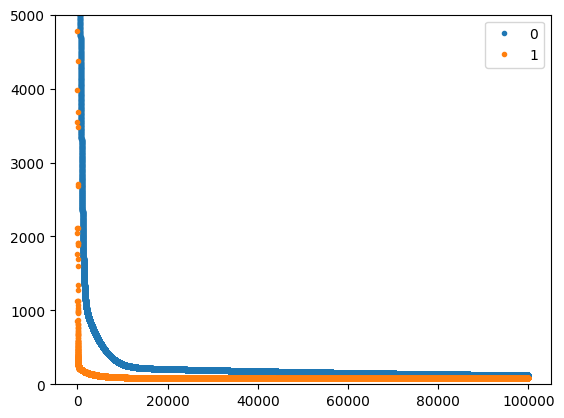

In [17]:
plt.plot(losses_1, '.')
plt.plot(losses_2, '.')
#plt.plot(losses_3, '--')
#plt.plot(losses_4, '--')
plt.ylim(0,5000)
plt.legend(range(2))
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

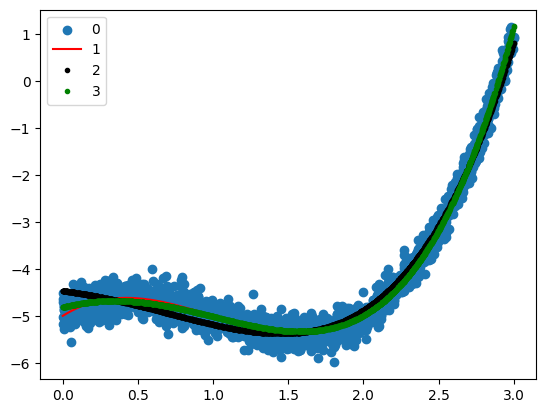

In [18]:
plt.scatter(X_train, y_train)
plt.plot(np.sort(X_train), f_trend(np.sort(X_train)), color='red')
plt.plot(np.sort(X_train), f_poly(np.sort(X_train), weights_1), '.', color='black')
plt.plot(np.sort(X_train), f_poly(np.sort(X_train), weights_2), '.', color='green')
#plt.plot(np.sort(X_train), f_poly(np.sort(X_train), weights_3), '--', color='blue')
#plt.plot(np.sort(X_train), f_poly(np.sort(X_train), weights_4), '--', color='yellow')
plt.legend(range(4))
plt.show